# Sequential wokflow

Sequential Workflow is a multi-agent design pattern where agents respond in a deterministic sequence. Each agent in the workflow performs a specific task by processing a message, generating a response, and then passing it to the next agent; useful for creating deterministic workflows where each agent contributes to a pre-specified sub-task.

The pipeline consists of four specialized agents:

- `Concept Extractor Agent`: Analyzes the initial product description to extract key features, target audience, and unique selling points (USPs). The output is a structured analysis in a single text block.

- `Writer Agent`: Crafts compelling marketing copy based on the extracted concepts. This agent transforms the analytical insights into engaging promotional content, delivering a cohesive narrative in a single text block.

- `Format & Proof Agent`: Polishes the draft copy by refining grammar, enhancing clarity, and maintaining consistent tone. This agent ensures professional quality and delivers a well-formatted final version.

- `User Agent`: Presents the final, refined marketing copy to the user, completing the workflow.

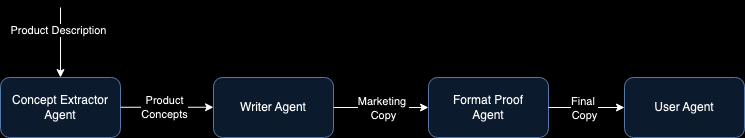

In [1]:
from pydantic import BaseModel


class Message(BaseModel):
    content: str

In [17]:
from enum import StrEnum, auto


class TopicType(StrEnum):
    CONCEPT_EXTRACTION = auto()
    WRITING = auto()
    FORMAT_PROOF = auto()
    USER = auto()

### completion model

In [9]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_VERSION")
_set_env("AZURE_OPENAI_DEPLOYMENT_NAME")
_set_env("AZURE_OPENAI_MODEL_NAME")

In [10]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient

model_client: AzureOpenAIChatCompletionClient = AzureOpenAIChatCompletionClient(
    model=os.getenv("AZURE_OPENAI_MODEL_NAME"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
)

In [ ]:
from autogen_core.models import UserMessage

llm_result = await model_client.create(
    messages=[
        UserMessage(content="Hi", source="user"),
    ],
    cancellation_token=None,
)
response = llm_result.content
print(response)

Hello! How can I assist you today?


### agents

In [23]:
from autogen_core import (
    type_subscription,
    RoutedAgent,
    MessageContext,
    message_handler,
    TopicId,
)

from autogen_core.models import ChatCompletionClient, SystemMessage, UserMessage


@type_subscription(topic_type=TopicType.CONCEPT_EXTRACTION)
class ConceptExtractorAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("A concept extractor agent.")
        self._system_message = SystemMessage(
            content=(
                "You are a marketing analyst. Given a product description, identify:\n"
                "- Key features\n"
                "- Target audience\n"
                "- Unique selling points\n\n"
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_user_description(
        self, message: Message, ctx: MessageContext
    ) -> None:
        prompt = f"Product description:\n\n{message.content}"
        llm_result = await self._model_client.create(
            messages=[
                self._system_message,
                UserMessage(content=prompt, source=self.id.key),
            ],
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content

        assert isinstance(response, str)
        print(f"{'-'*80}\n{self.id.type}:\n{response}")

        await self.publish_message(
            Message(content=response),
            topic_id=TopicId(TopicType.WRITING, source=self.id.key),
        )

In [24]:
@type_subscription(topic_type=TopicType.WRITING)
class WriterAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("A writer agent.")
        self._system_message = SystemMessage(
            content=(
                "You are a marketing copywriter. Given a block of text describing features, audience, and USPs, "
                "compose a compelling marketing copy (like a newsletter section) that highlights these points. "
                "Output should be short (around 150 words), output just the copy as a single text block."
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_intermediate_text(
        self, message: Message, ctx: MessageContext
    ) -> None:
        prompt = f"Below is the info about the product:\n\n{message.content}"

        llm_result = await self._model_client.create(
            messages=[
                self._system_message,
                UserMessage(content=prompt, source=self.id.key),
            ],
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content
        assert isinstance(response, str)
        print(f"{'-'*80}\n{self.id.type}:\n{response}")

        await self.publish_message(
            Message(content=response),
            topic_id=TopicId(TopicType.FORMAT_PROOF, source=self.id.key),
        )

In [ ]:
@type_subscription(topic_type=TopicType.FORMAT_PROOF)
class FormatProofAgent(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("A format & proof agent.")
        self._system_message = SystemMessage(
            content=(
                "You are an editor. Given the draft copy, correct grammar, improve clarity, ensure consistent tone, "
                "give format and make it polished. Output the final improved copy as a single text block."
            )
        )
        self._model_client = model_client

    @message_handler
    async def handle_intermediate_text(
        self, message: Message, ctx: MessageContext
    ) -> None:
        prompt = f"Draft copy:\n{message.content}."
        llm_result = await self._model_client.create(
            messages=[
                self._system_message,
                UserMessage(content=prompt, source=self.id.key),
            ],
            cancellation_token=ctx.cancellation_token,
        )
        response = llm_result.content

        assert isinstance(response, str)
        print(f"{'-'*80}\n{self.id.type}:\n{response}")

        await self.publish_message(
            Message(content=response),
            topic_id=TopicId(TopicType.USER, source=self.id.key),
        )

In [26]:
@type_subscription(topic_type=TopicType.USER)
class UserAgent(RoutedAgent):
    def __init__(self) -> None:
        super().__init__("A user agent that outputs the final copy to the user.")

    @message_handler
    async def handle_final_copy(self, message: Message, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type} received final copy:\n{message.content}")

### runtime

In [27]:
from autogen_core import SingleThreadedAgentRuntime

runtime: SingleThreadedAgentRuntime = SingleThreadedAgentRuntime()

await ConceptExtractorAgent.register(
    runtime,
    type=TopicType.CONCEPT_EXTRACTION,
    factory=lambda: ConceptExtractorAgent(model_client=model_client),
)

await WriterAgent.register(
    runtime,
    type=TopicType.WRITING,
    factory=lambda: WriterAgent(model_client=model_client),
)

await FormatProofAgent.register(
    runtime,
    type=TopicType.FORMAT_PROOF,
    factory=lambda: FormatProofAgent(model_client=model_client),
)

await UserAgent.register(runtime, type=TopicType.USER, factory=lambda: UserAgent())

AgentType(type=<TopicType.USER: 'user'>)

In [28]:
runtime.start()

await runtime.publish_message(
    Message(
        content="An eco-friendly stainless steel water bottle that keeps drinks cold for 24 hours"
    ),
    topic_id=TopicId(TopicType.CONCEPT_EXTRACTION, source="default"),
)

await runtime.stop_when_idle()

--------------------------------------------------------------------------------
concept_extraction:
- **Key Features:**
  - Made from eco-friendly stainless steel
  - Insulates drinks to keep them cold for up to 24 hours
  - Durable and long-lasting design
  - Reusable, reducing plastic waste
  - Portable and lightweight

- **Target Audience:**
  - Environmentally conscious consumers
  - Outdoor enthusiasts (hikers, campers, cyclists)
  - Fitness enthusiasts (gym-goers, runners)
  - Office workers seeking sustainable options
  - Parents looking for safe and durable hydration solutions for their children

- **Unique Selling Points:**
  - Sustainability: Made from eco-friendly materials, appealing to eco-conscious buyers.
  - Exceptional insulation: Keeps beverages cold for an impressive 24 hours, suitable for all-day adventures.
  - Versatile design: Ideal for a variety of activities, from outdoor adventures to everyday use.
  - Encourages a zero-waste lifestyle by promoting reusable o